In [39]:
%load_ext autoreload
%autoreload 2
from methods2final import * 
sc.settings.verbosity = 3  
results_file = '../dat/write/pfc2018.h5ad'
sc.settings.set_figure_params(dpi=160)

device = torch.device('cuda:1')
torch.cuda.set_device(1)
print(torch.cuda.current_device())
#X = X.to(device)
def to_var(x):
    return x.to(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1


In [40]:
adata = sc.read_h5ad(results_file)
adata

AnnData object with n_obs × n_vars = 2378 × 4490 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'ID', 'week'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'gene'
    uns: 'pca', 'week_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [41]:
batch_size = 256
dataset = torch.tensor(adata.X)
tensor_max_value = torch.max(dataset)
dataset = dataset/tensor_max_value
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [42]:
vae = VAE(image_size=4490)
if torch.cuda.is_available():
    print("Model on GPU")
    vae.cuda()
vae

Model on GPU


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=4490, out_features=400, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=400, out_features=800, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=4490, bias=True)
    (3): Sigmoid()
  )
)

In [44]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train(data_loader, vae, optimizer, batch_size, epochs=500)

Epoch[1/500] Loss: 79.253
Epoch[11/500] Loss: 72.891
Epoch[21/500] Loss: 72.589
Epoch[31/500] Loss: 76.453
Epoch[41/500] Loss: 85.206
Epoch[51/500] Loss: 73.851
Epoch[61/500] Loss: 77.414
Epoch[71/500] Loss: 71.380
Epoch[81/500] Loss: 77.076
Epoch[91/500] Loss: 78.643
Epoch[101/500] Loss: 74.952
Epoch[111/500] Loss: 77.291
Epoch[121/500] Loss: 75.341
Epoch[131/500] Loss: 78.966
Epoch[141/500] Loss: 72.707
Epoch[151/500] Loss: 74.953
Epoch[161/500] Loss: 69.821
Epoch[171/500] Loss: 74.541
Epoch[181/500] Loss: 73.001
Epoch[191/500] Loss: 77.721
Epoch[201/500] Loss: 75.046
Epoch[211/500] Loss: 76.036
Epoch[221/500] Loss: 79.471
Epoch[231/500] Loss: 76.293
Epoch[241/500] Loss: 76.300
Epoch[251/500] Loss: 73.543
Epoch[261/500] Loss: 70.577
Epoch[271/500] Loss: 73.224
Epoch[281/500] Loss: 71.458
Epoch[291/500] Loss: 74.275
Epoch[301/500] Loss: 75.884
Epoch[311/500] Loss: 69.198
Epoch[321/500] Loss: 75.889
Epoch[331/500] Loss: 72.510
Epoch[341/500] Loss: 71.355
Epoch[351/500] Loss: 73.901
Epo

In [45]:
rec_X = vae(to_var(dataset))
print(len(rec_X[0]))
rec_X = rec_X[0].data.cpu()
X = (rec_X*tensor_max_value).detach().numpy()
X.shape
adata.X = X

2378


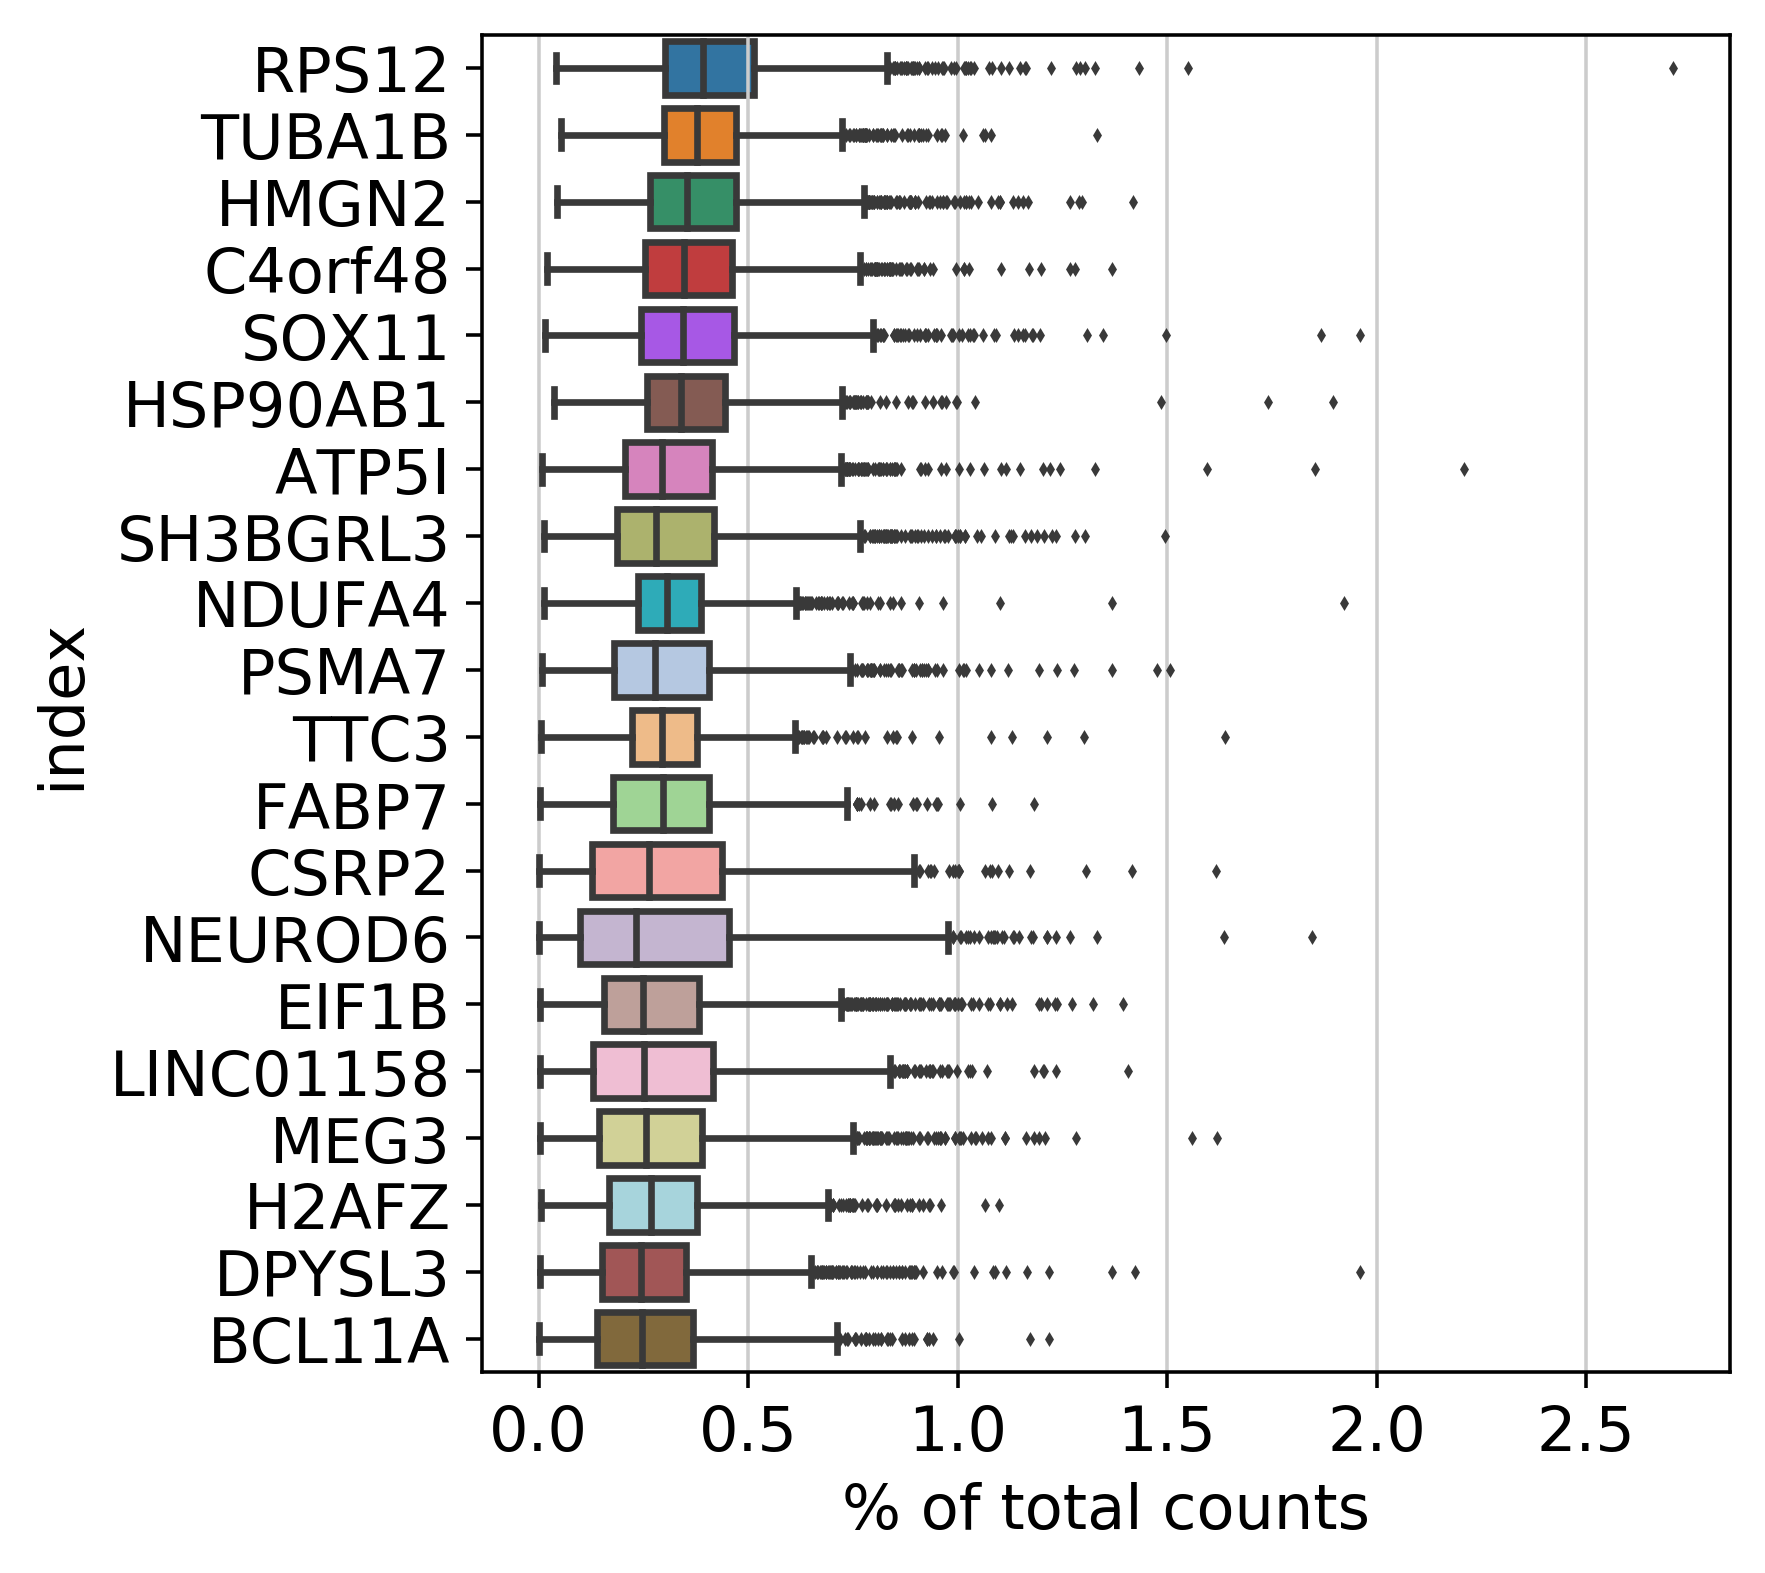

In [46]:
sc.pl.highest_expr_genes(adata, n_top=20)

computing PCA on highly variable genes


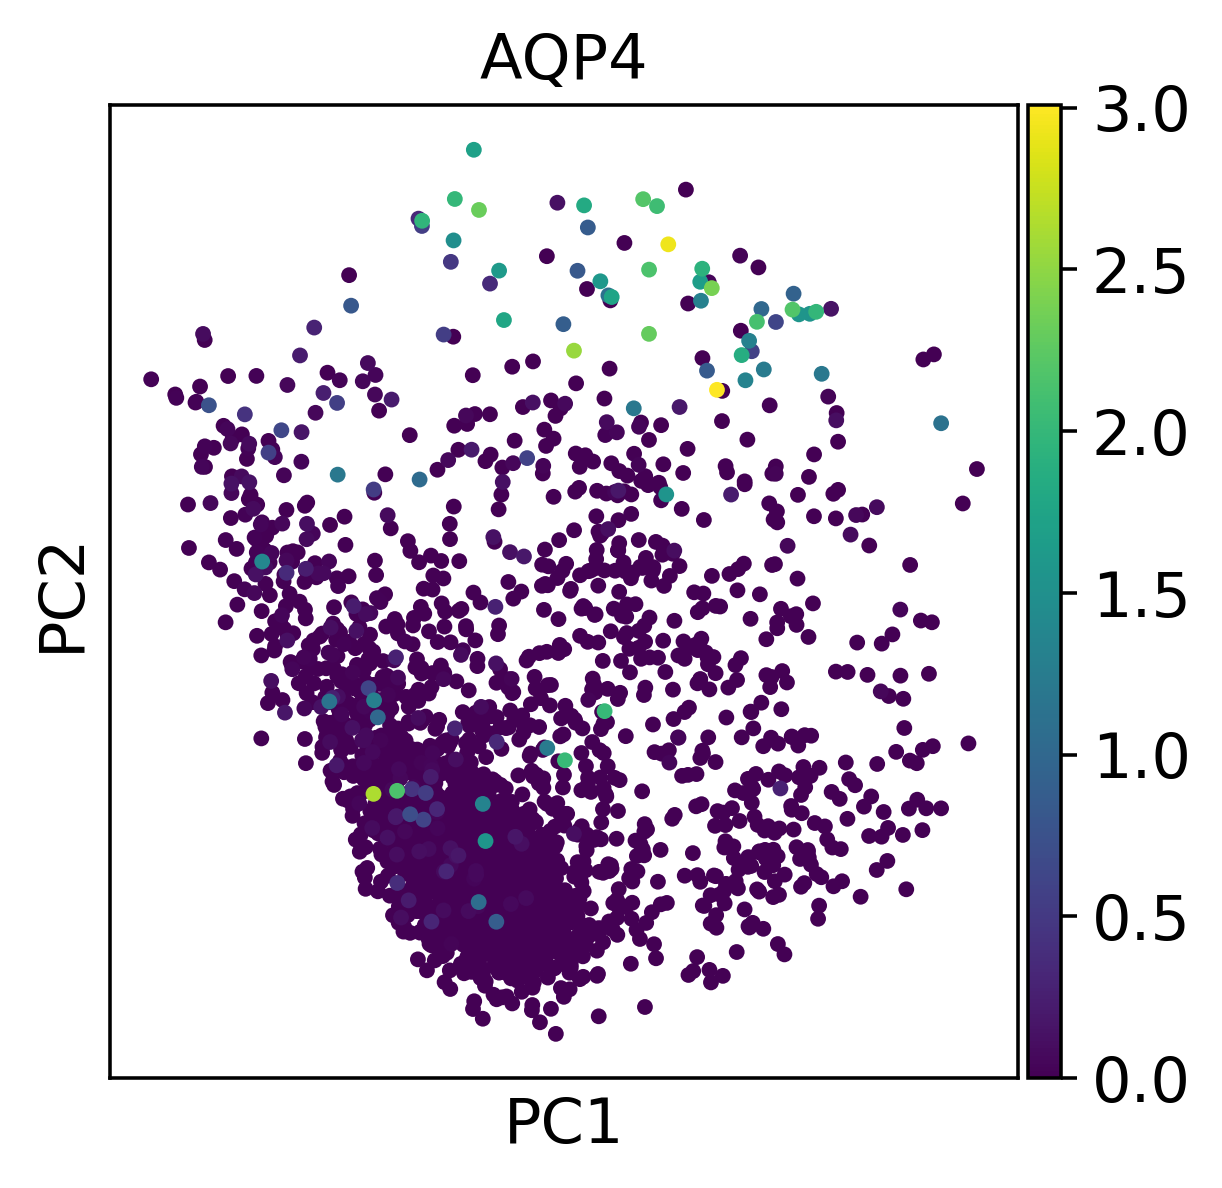

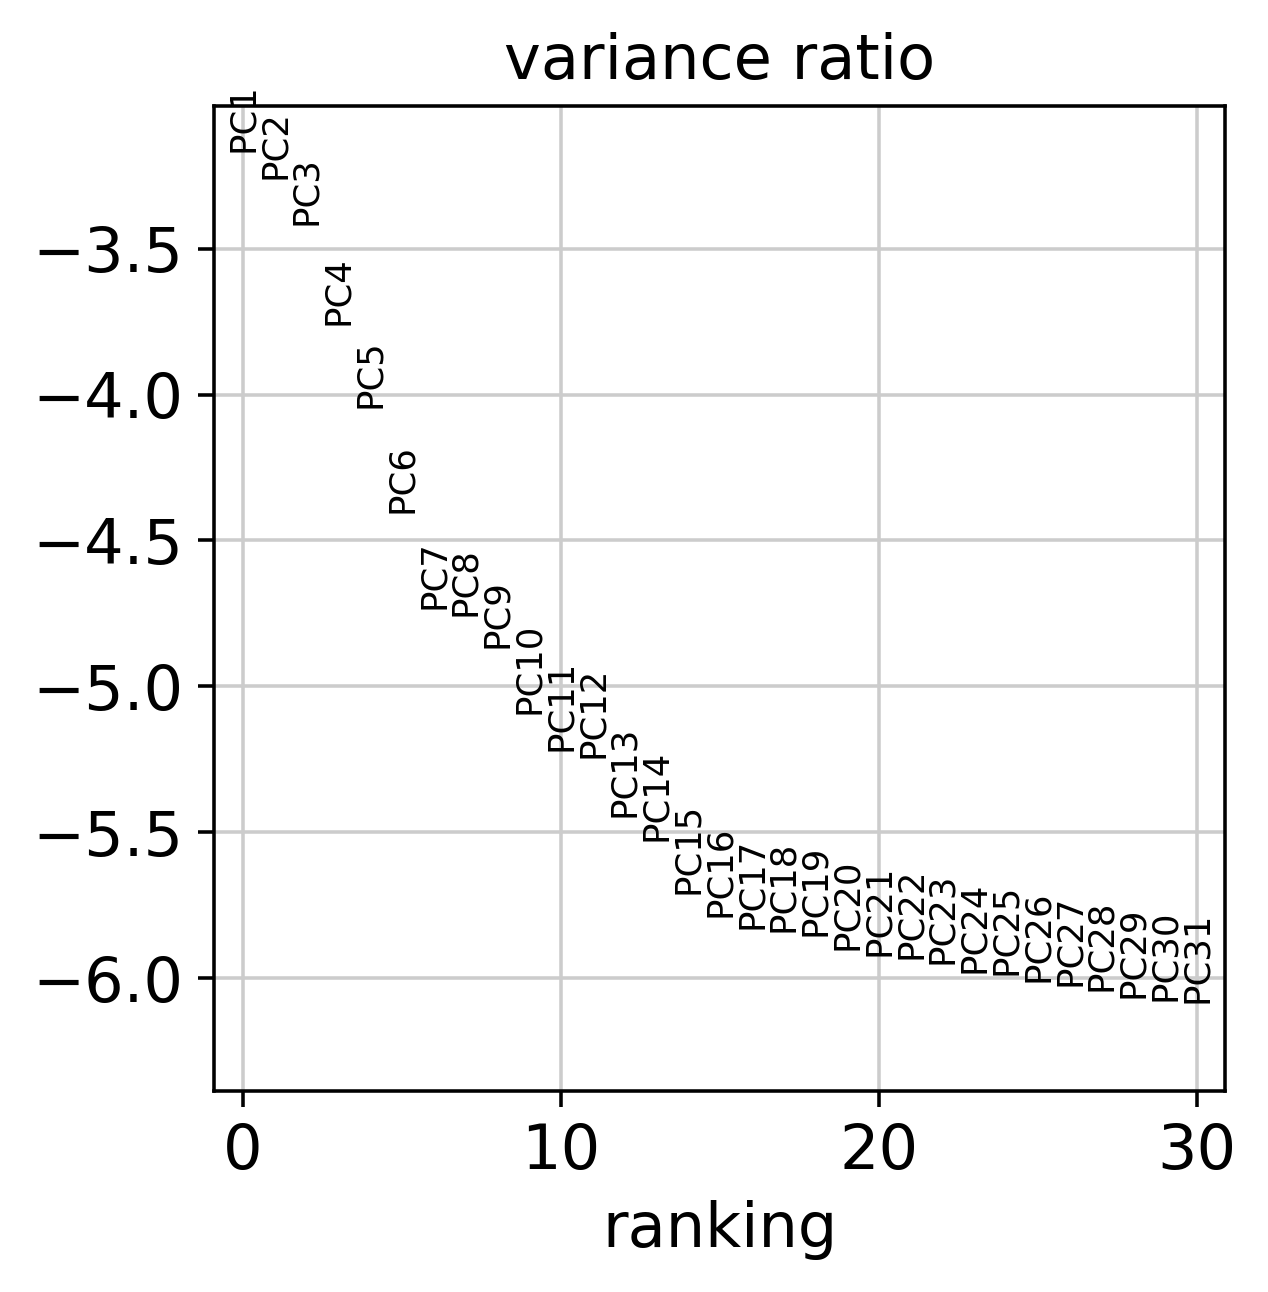

In [47]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='AQP4')
sc.pl.pca_variance_ratio(adata, log=True)

In [48]:
sc.tl.tsne(adata, use_rep='X')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:25.78) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


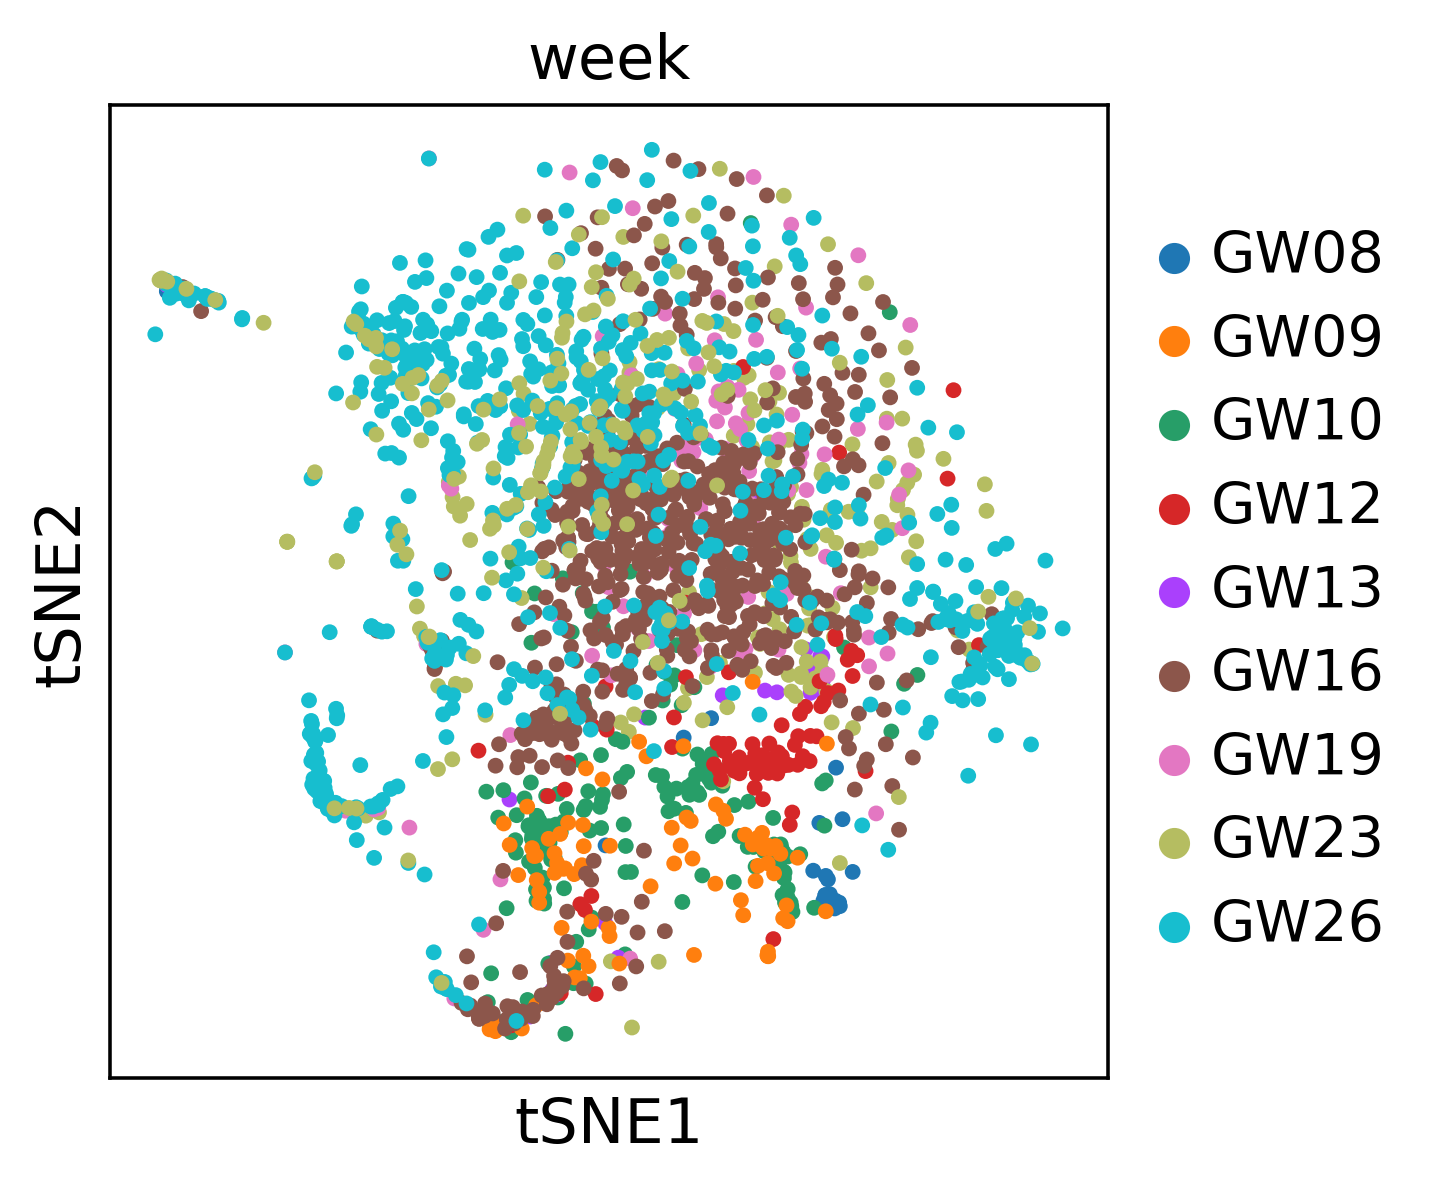

In [49]:
sc.pl.tsne(adata, color='week')

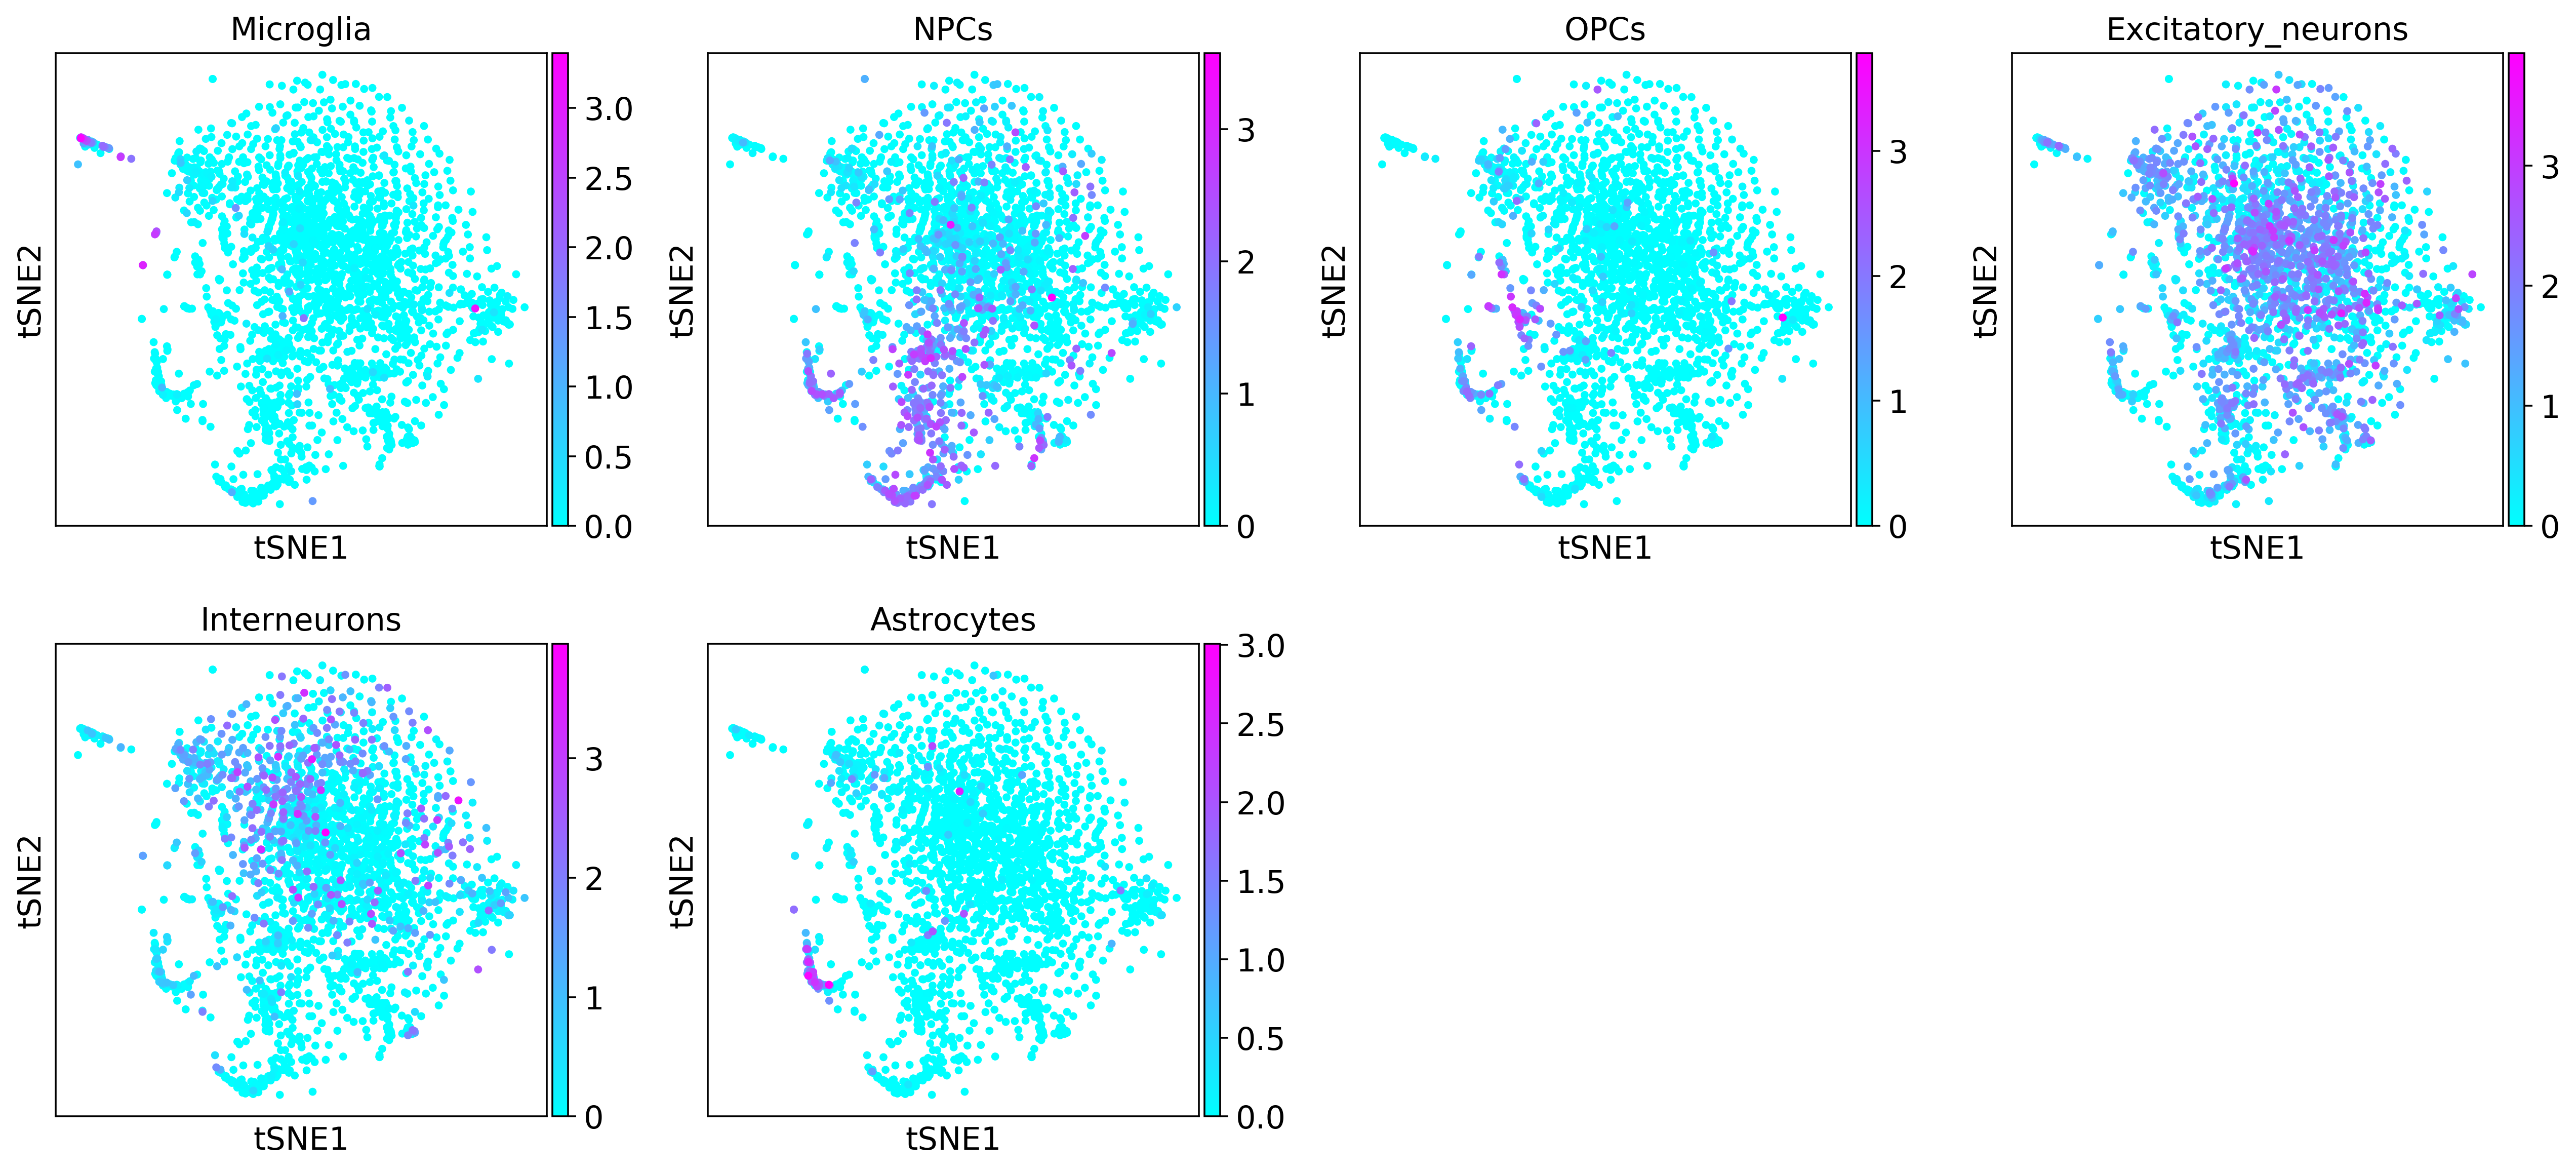

In [50]:
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")

In [51]:
codes = vae.encoder(to_var(dataset))
codes = codes.cpu().detach().numpy()
adata.obsm["X_code400"] = codes

In [52]:
sc.tl.tsne(adata, use_rep='X_code400')

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:12.16) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


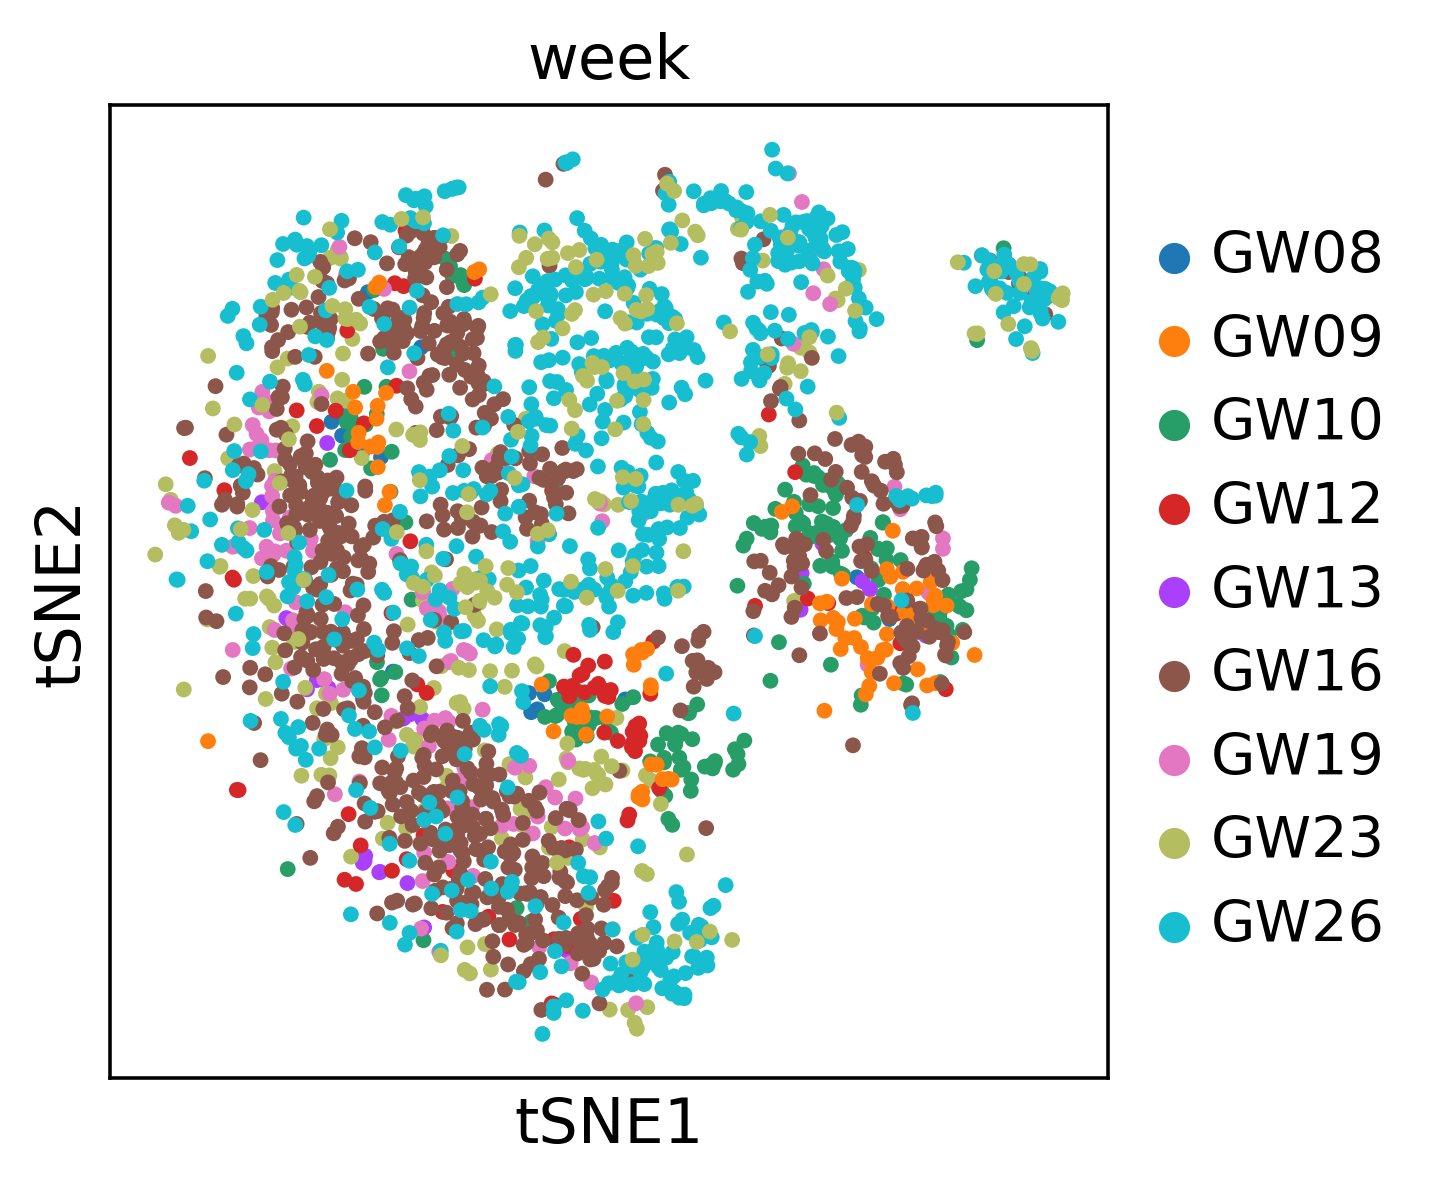

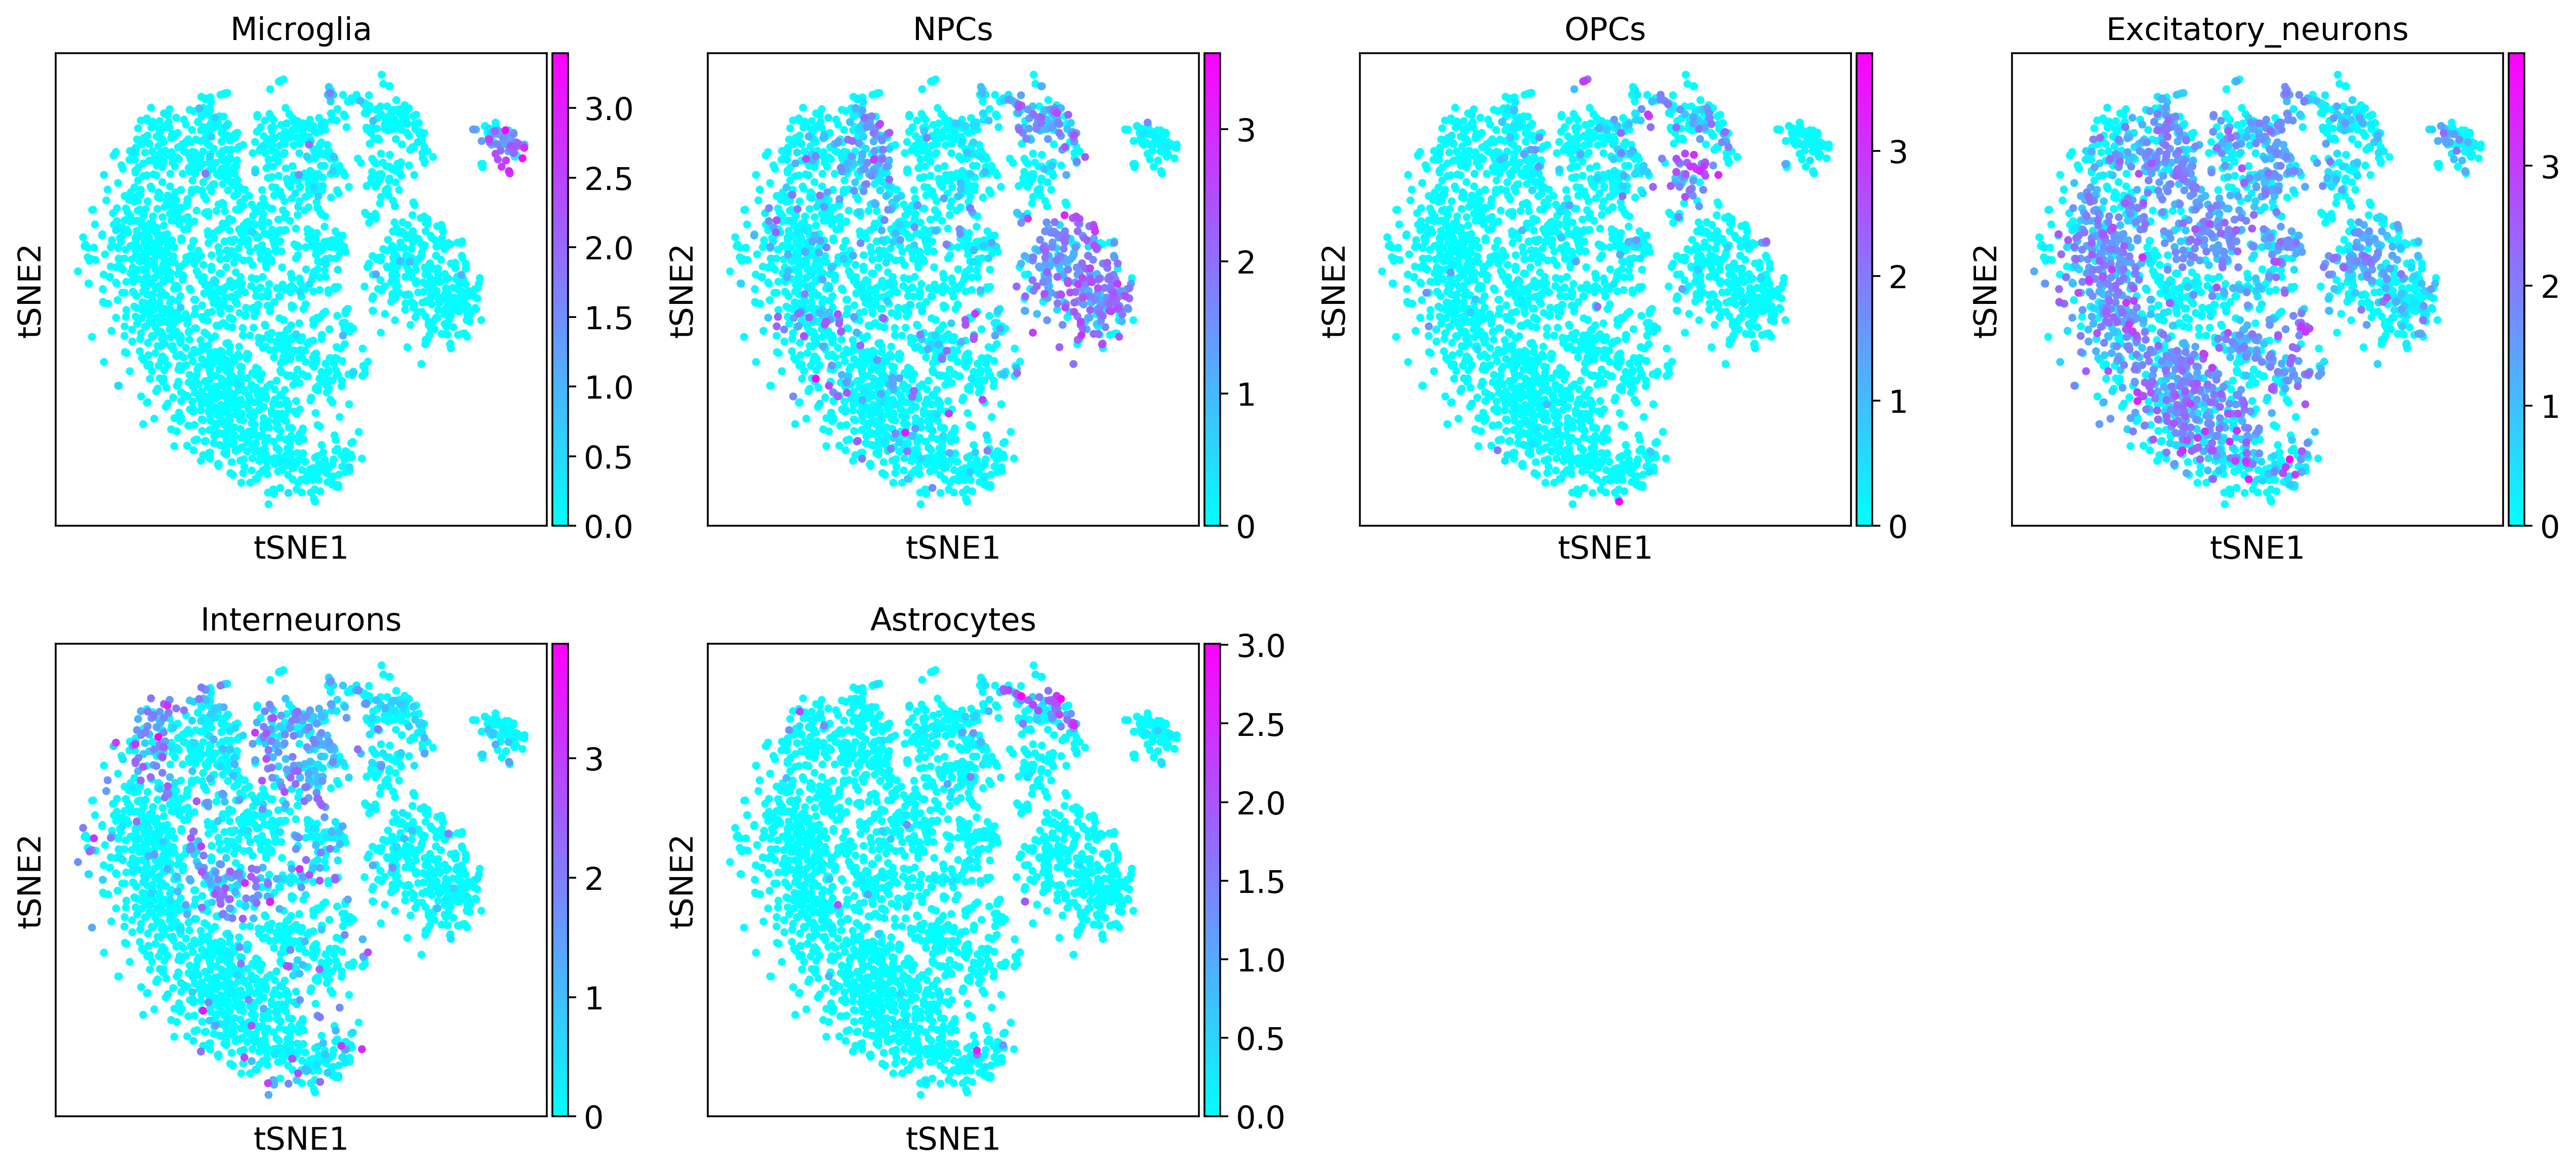

In [53]:
sc.pl.tsne(adata, color='week')
genes = ["PTPRC", "PAX6", "PMP2", "NEUROD2", "GAD1", "AQP4"]
titles = ["Microglia", "NPCs", "OPCs", "Excitatory_neurons", "Interneurons", "Astrocytes"]
sc.pl.tsne(adata, color=genes, title=titles, color_map="cool")